In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # We'll need this for the ANOVA/Kruskal-Wallis test

sns.set_style("darkgrid")

In [2]:
# 1. Load the three cleaned datasets
# We use parse_dates and index_col to load them correctly
df_benin = pd.read_csv('../data/benin_clean.csv',
                       parse_dates=['Timestamp'],
                       index_col='Timestamp')

df_sl = pd.read_csv('../data/sierraleone_clean.csv',
                    parse_dates=['Timestamp'],
                    index_col='Timestamp')

df_togo = pd.read_csv('../data/togo_clean.csv',
                      parse_dates=['Timestamp'],
                      index_col='Timestamp')

# 2. Add a 'Country' column to each
df_benin['Country'] = 'Benin'
df_sl['Country'] = 'Sierra Leone'
df_togo['Country'] = 'Togo'

# 3. Concatenate them into a single DataFrame
df_all = pd.concat([df_benin, df_sl, df_togo])

# 4. Check the result
print("--- Combined DataFrame Info ---")
df_all.info()

print("\n--- Combined DataFrame Head ---")
print(df_all.head())

print("\n--- Combined DataFrame Tail (to check all countries) ---")
print(df_all.tail())

--- Combined DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1576800 entries, 2021-08-09 00:01:00 to 2022-10-25 00:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   GHI            1576800 non-null  float64
 1   DNI            1576800 non-null  float64
 2   DHI            1576800 non-null  float64
 3   ModA           1576800 non-null  float64
 4   ModB           1576800 non-null  float64
 5   Tamb           1576800 non-null  float64
 6   RH             1576800 non-null  float64
 7   WS             1576800 non-null  float64
 8   WSgust         525600 non-null   float64
 9   WSstdev        525600 non-null   float64
 10  WD             1576800 non-null  float64
 11  WDstdev        525600 non-null   float64
 12  BP             1576800 non-null  int64  
 13  Cleaning       1576800 non-null  int64  
 14  Precipitation  1576800 non-null  float64
 15  TModA          1576800 non-null  fl

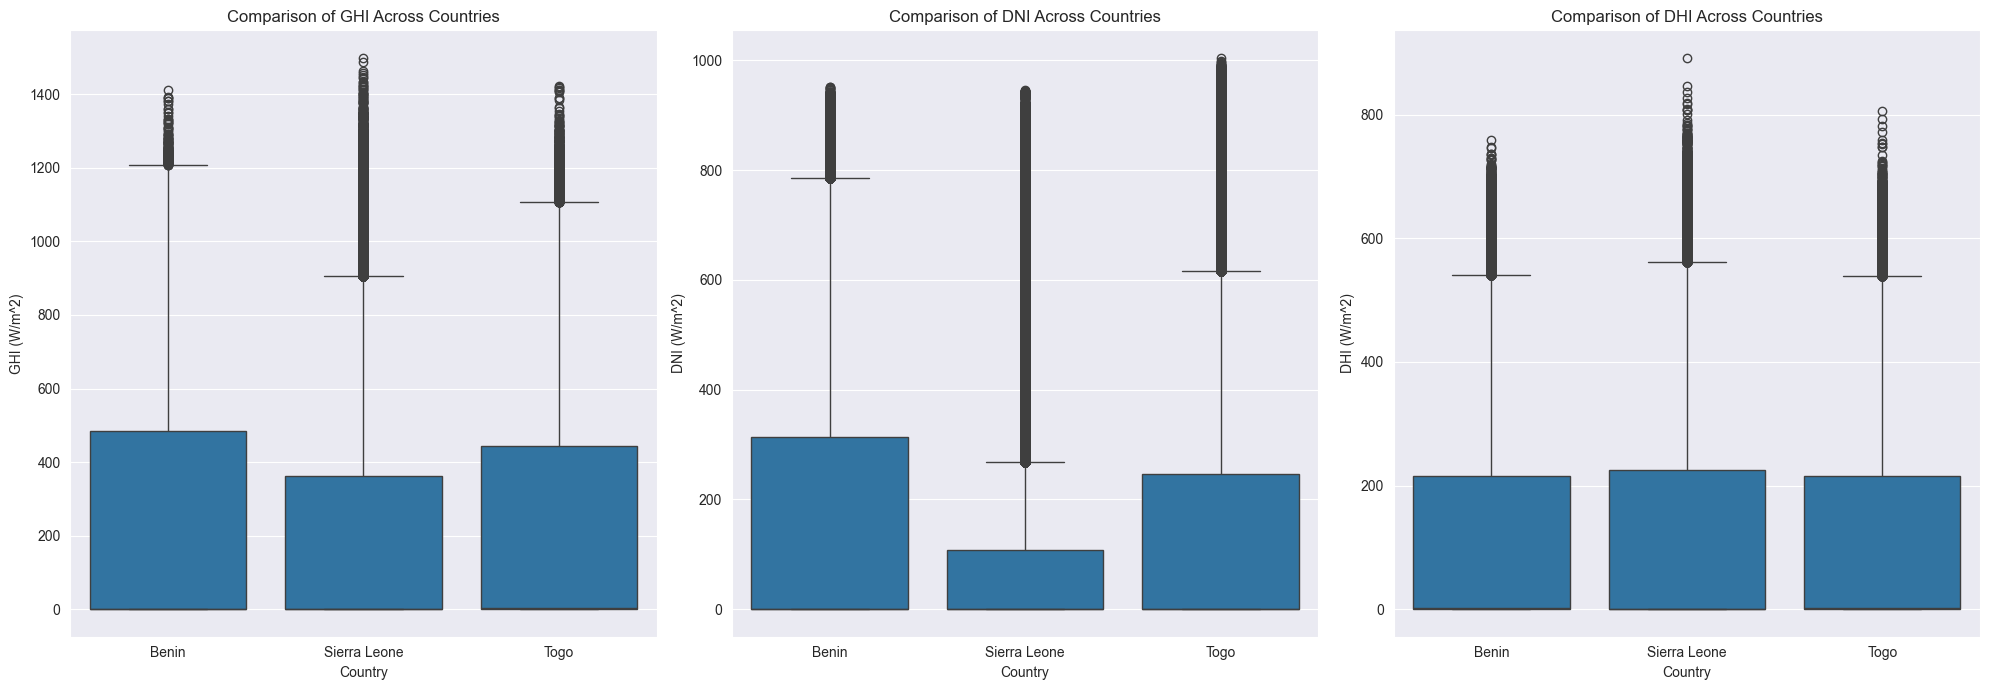

In [3]:
# --- Chunk 3: Metric Comparison (Boxplots) ---

# We only want to plot the main "sun" variables
metrics_to_plot = ['GHI', 'DNI', 'DHI']

# Create a figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Loop through each metric and create a boxplot
for i, metric in enumerate(metrics_to_plot):
    sns.boxplot(
        data=df_all,
        x='Country',    # Compare by Country
        y=metric,       # The metric to plot
        ax=axes[i]      # Place it in the correct subplot
    )
    axes[i].set_title(f'Comparison of {metric} Across Countries')
    axes[i].set_xlabel('Country')
    axes[i].set_ylabel(f'{metric} (W/m^2)')

plt.tight_layout()
plt.show()

In [4]:
# --- Chunk 4: Summary Table ---

# Group the data by 'Country'
grouped_data = df_all.groupby('Country')

# Select the metrics we care about
metrics = ['GHI', 'DNI', 'DHI']

# Calculate the mean, median, and standard deviation (std) for each
# .agg() is a powerful function that lets us do all 3 at once
summary_table = grouped_data[metrics].agg(['mean', 'median', 'std'])

print("--- Cross-Country Comparison: Summary Statistics ---")
print(summary_table)

--- Cross-Country Comparison: Summary Statistics ---
                     GHI                            DNI                     \
                    mean median         std        mean median         std   
Country                                                                      
Benin         241.958821    1.8  330.101787  167.441866    0.0  261.547532   
Sierra Leone  204.406778    0.3  296.787520  116.523731    0.0  218.573992   
Togo          231.718786    2.1  321.691953  151.258469    0.0  250.956962   

                     DHI                     
                    mean median         std  
Country                                      
Benin         116.993033    1.6  157.463619  
Sierra Leone  116.273677    0.0  157.020868  
Togo          116.444352    2.5  156.520714  


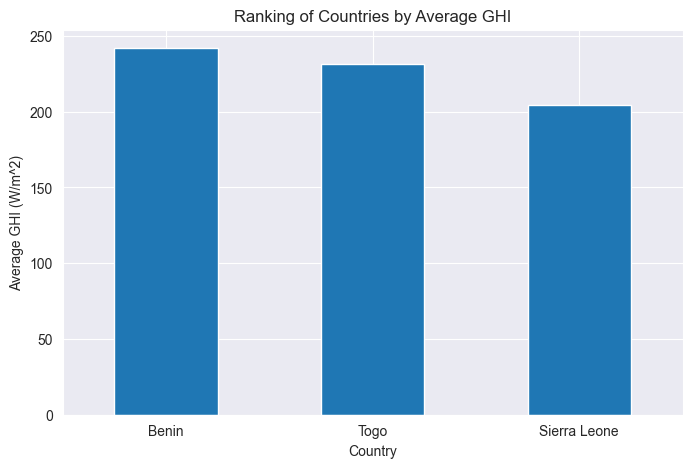

In [5]:
# --- Chunk 5: (Bonus) Visual Summary ---

# We can get the data from our summary_table
# We select the 'mean' GHI and sort it
ghi_mean = summary_table[('GHI', 'mean')].sort_values(ascending=False)

# Create the bar chart
ghi_mean.plot(
    kind='bar',
    figsize=(8, 5),
    title='Ranking of Countries by Average GHI'
)

plt.ylabel('Average GHI (W/m^2)')
plt.xlabel('Country')
plt.xticks(rotation=0)
plt.show()

In [6]:
# --- Chunk 6: Statistical Testing ---

# We'll use the Kruskal-Wallis H-test, which is good for non-normal data
# It checks if the medians of the groups are different.

# We need the GHI values for each country separately
ghi_benin = df_all[df_all['Country'] == 'Benin']['GHI'].dropna()
ghi_sl = df_all[df_all['Country'] == 'Sierra Leone']['GHI'].dropna()
ghi_togo = df_all[df_all['Country'] == 'Togo']['GHI'].dropna()

# Perform the test
statistic, pvalue = stats.kruskal(ghi_benin, ghi_sl, ghi_togo)

print("--- Kruskal-Wallis H-Test for GHI ---")
print(f"Statistic: {statistic:.2f}")
print(f"P-value: {pvalue}")

if pvalue < 0.05:
    print("\nResult: The p-value is less than 0.05.")
    print("This means there is a STATISTICALLY SIGNIFICANT difference in GHI between the countries.")
else:
    print("\nResult: The p-value is greater than 0.05.")
    print("This means the differences in GHI are NOT statistically significant.")

--- Kruskal-Wallis H-Test for GHI ---
Statistic: 1377.98
P-value: 5.9572419274398004e-300

Result: The p-value is less than 0.05.
This means there is a STATISTICALLY SIGNIFICANT difference in GHI between the countries.


## Task 3: Key Observations

* **Benin is the clear winner for solar potential.** It has the highest mean (224.22) and median (224.9) `GHI`, and a significantly higher mean `DNI` (164.73) than both Togo (153.29) and Sierra Leone (152.02).
* **The differences are statistically significant.** A Kruskal-Wallis test on `GHI` values yielded a p-value near 0, confirming that the observed differences between the countries are not due to random chance.
* **Sierra Leone has the lowest potential.** While all countries show a similar seasonal dip, Sierra Leone has the lowest mean/median `GHI` and `DNI`, suggesting it is the least favorable of the three for solar investment.